In [1]:
import numpy as np
from sklearn.externals import joblib
import copy
import random
import math
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn import metrics

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
mp.rcParams.update({'font.size': 22})

In [4]:
datadict = joblib.load("Two_Port_Standard_Dictionary_Cleaned_Interpolated.pkl")

In [5]:
system_device_combos = [
    ["CTN210","System 2,7"],
    ['C14202','System 2,7'],
    ['CTN209','System 2,7'],
]

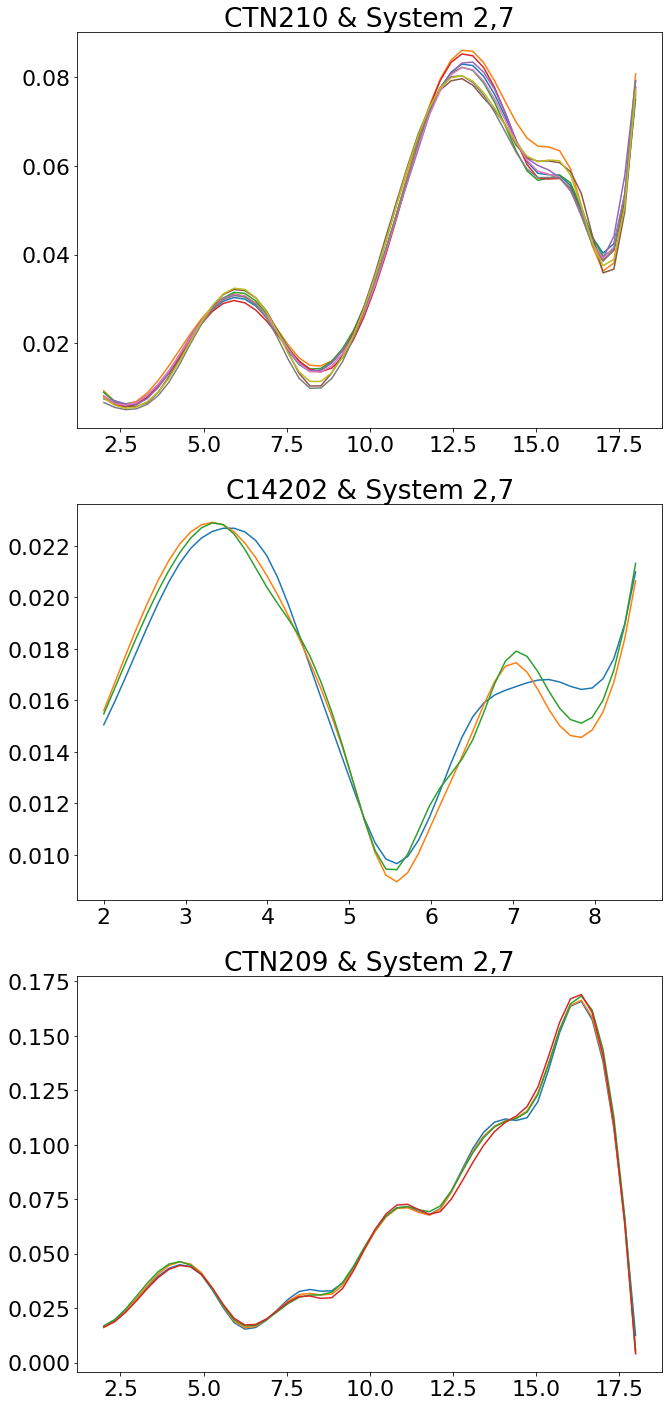

In [6]:
plt.figure(figsize=(10,20))
for i,combo in enumerate(system_device_combos):
    plt.subplot(len(system_device_combos),1,i+1)
    plt.title(combo[0] + " & " + combo[1])
    combo_data = datadict[combo[0]][combo[1]]
    for key in combo_data.keys():
        frequency_range = combo_data[key]["Frequency"]
        plt.plot(frequency_range,combo_data[key]["magS22"])
plt.tight_layout()
plt.show()

In [7]:
system_magS22_deviations = [0.0025, 0.0005, 0.005]

In [8]:
def make_fake_magS22_data(base_data, mag_deviation, num_fake_points):
    magS22_points = []
    for i in range(num_fake_points):
        new_dataset = copy.deepcopy(base_data[random.choice(base_data.keys())])
        new_dataset["magS22"] += np.random.normal(0,mag_deviation,50)
        magS22_points.append(new_dataset["magS22"].tolist())
    return np.array(magS22_points)

In [9]:
def do_classification_stuff(data,randomness_amplitude,classifier):
    #Producing Bad Data
    incorrect_magS22_data = copy.deepcopy(data)
    for i in range(len(incorrect_magS22_data)):
        incorrect_magS22_data[i] = (incorrect_magS22_data[i] + np.random.normal(0,randomness_amplitude,50))
    #Making training and test data
    S22_training_data = []
    S22_training_data.extend(incorrect_magS22_data.tolist())
    S22_training_data.extend(data.tolist())
    S22_training_data_arr = np.array(S22_training_data)
    targets = ["not valid","valid"]
    S22_target_arr = np.repeat(targets,len(data))
    S22_training_data_arr,S22_target_arr = shuffle(S22_training_data_arr,S22_target_arr, random_state=0)
    #Cloning and Training Classifier
    clf = clone(classifier)
    clf.fit(S22_training_data_arr[:len(data)],S22_target_arr[:len(data)])
    #Predicting Stuff
    predicted = clf.predict(S22_training_data_arr[len(data):])
    #Getting prediction data
    valid_prediction_data = []
    invalid_prediction_data = []
    for i in range(len(predicted)):
        if predicted[i] == "valid":
            valid_prediction_data.append(S22_training_data_arr[len(data) + i])
        else:
            invalid_prediction_data.append(S22_training_data_arr[len(data) + i])
    return (valid_prediction_data, invalid_prediction_data)

In [10]:
randomness_amplitudes = [
    [0.0005,0.0025,0.01,0.02,0.05],
    [0.0001,0.0005,0.002,0.005,0.01],
    [0.001,0.005,0.02,0.05,0.1]
]

In [11]:
classifier = RandomForestClassifier()
plt.figure(figsize=(8*len(randomness_amplitudes[0]),6*len(system_device_combos)))
j=1
num_plot_points = 500
for index in range(len(system_device_combos)):
    fake_data = make_fake_magS22_data(datadict[system_device_combos[index][0]][system_device_combos[index][1]],
                                     system_magS22_deviations[index],
                                     15000)
    for amp in randomness_amplitudes[index]:
        plt.subplot(len(system_device_combos),len(randomness_amplitudes[0]),j)
        valid_prediction_data,invalid_prediction_data = do_classification_stuff(fake_data,amp,classifier)
        plt.title("Device: " + system_device_combos[index][0] + 
                  "\nSystem: " + system_device_combos[index][1] + 
                  "\nRandomness Amplitude: " + str(amp))
        if(len(invalid_prediction_data) >= num_plot_points):
            for i in range(num_plot_points):
                plt.plot(frequency_range,invalid_prediction_data[i],"b")
        else:
            for i in range(len(invalid_prediction_data)):
                plt.plot(frequency_range,invalid_prediction_data[i],"b")
        if(len(valid_prediction_data) >= num_plot_points):
            for i in range(num_plot_points):
                plt.plot(frequency_range,valid_prediction_data[i],"r")
        else:
            for i in range(len(valid_prediction_data)):
                plt.plot(frequency_range,valid_prediction_data[i],"r")
        j+=1
    print "Finished a system-device pair!"

Finished a system-device pair!
Finished a system-device pair!
Finished a system-device pair!


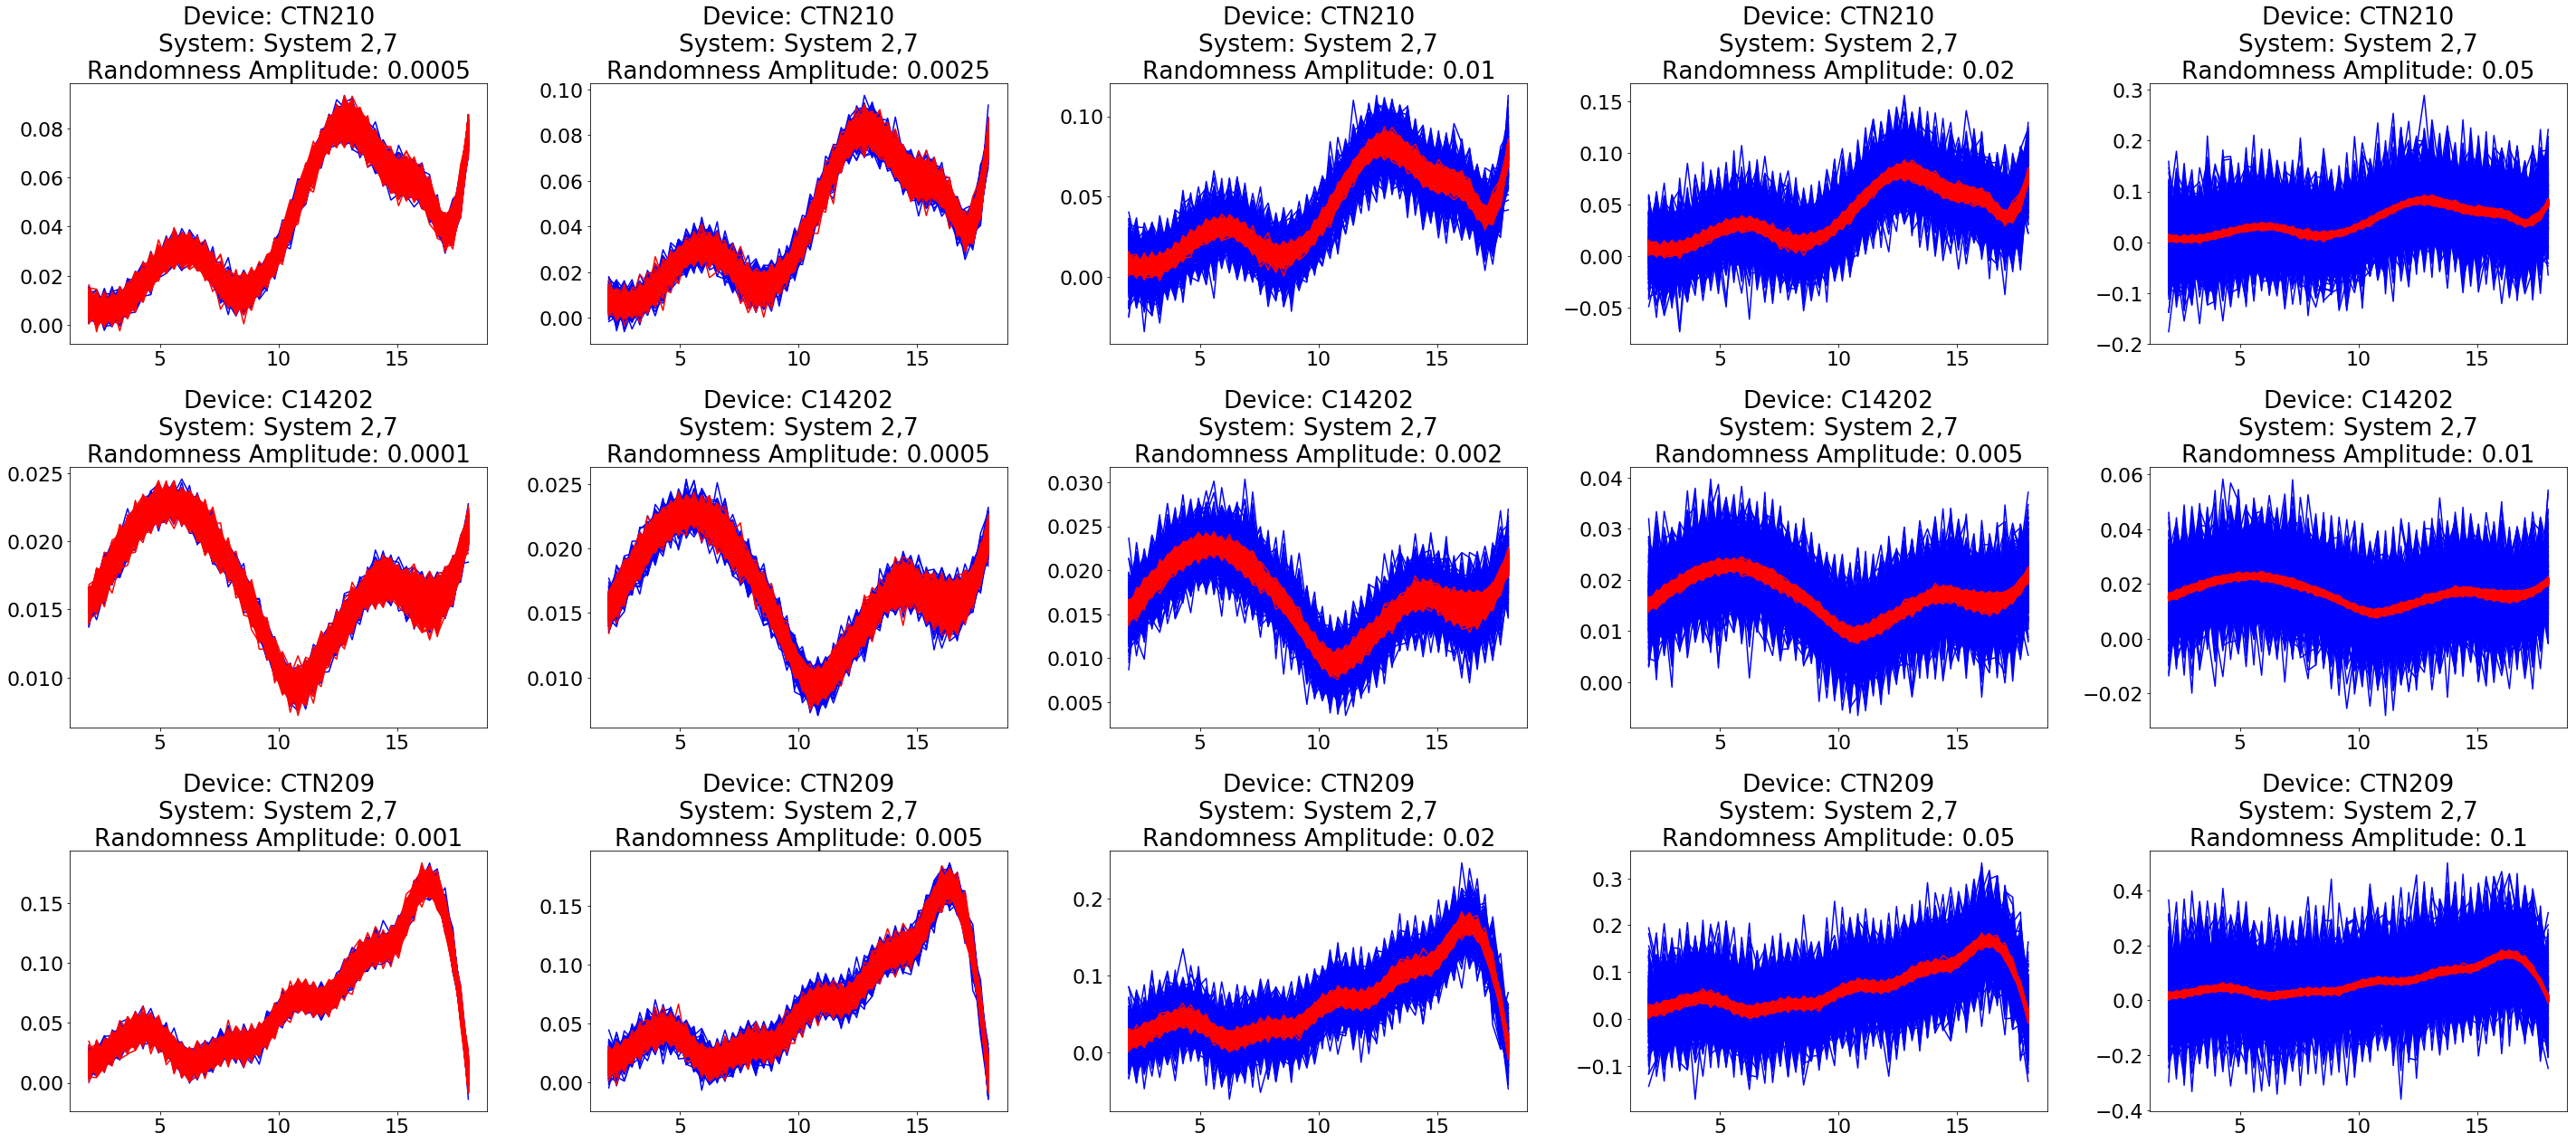

In [12]:
plt.tight_layout()
plt.show()